In [116]:
import sys
sys.path.append('./weightflow')  # e.g., './repo_name'

import torch
import numpy as np
from collections import defaultdict
from typing import NamedTuple
from scipy.optimize import linear_sum_assignment

from nn.relational_transformer import RelationalTransformer # not used by Saumya?
from nn.graph_constructor import GraphConstructor # not used by Saumya?

from flow.flow_matching import CFM
from tqdm import tqdm
import copy
import logging
from utils.data import sample_gaussian_wsos

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
from collections import defaultdict
import os
import traceback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')


# PermutationSpec class similar to the JAX version but using PyTorch
class PermutationSpec(NamedTuple):
    perm_to_axes: dict
    axes_to_perm: dict

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
    perm_to_axes = defaultdict(list)
    for wk, axis_perms in axes_to_perm.items():
        for axis, perm in enumerate(axis_perms):
            if perm is not None:
                perm_to_axes[perm].append((wk, axis))
    return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec_mlp() -> PermutationSpec:
    """Define permutation spec for MLP architecture"""
    return permutation_spec_from_axes_to_perm({
        "fc1.weight": (None, "P_0"),       # Input (None) to fc1 output (P_0)
        "fc1.bias": ("P_0",),              # Bias for fc1 output (P_0)
        "fc2.weight": ("P_0", "P_1"),      # fc1 output (P_0) to fc2 output (P_1)
        "fc2.bias": ("P_1",),              # Bias for fc2 output (P_1)
        "fc3.weight": ("P_1", None),       # fc2 output (P_1) to fc3 output (None)
        "fc3.bias": (None,),               # Bias for fc3 output (None)
    })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
    """Get parameter k from params, with permutations applied."""
    w = params[k]
    for axis, p in enumerate(ps.axes_to_perm[k]):
        # Skip the axis we're trying to permute
        if axis == except_axis:
            continue

        # None indicates no permutation for that axis
        if p is not None:
            w = torch.index_select(w, axis, torch.tensor(perm[p], device=w.device))

    return w

def apply_permutation(ps: PermutationSpec, perm, params):
    """Apply permutation to params"""
    return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None, silent=True, device=None):
    """Find permutation of params_b to make them match params_a."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move all tensors to the correct device
    params_a = {k: v.to(device) for k, v in params_a.items()}
    params_b = {k: v.to(device) for k, v in params_b.items()}

    # Get permutation sizes from the first parameter with each permutation
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] 
                  for p, axes in ps.perm_to_axes.items()}
    
    # Initialize permutations to identity if none provided
    if init_perm is None:
        perm = {p: torch.arange(n, device=device) for p, n in perm_sizes.items()}
    else:
        perm = {p: v.to(device) for p, v in init_perm.items()}
        
    perm_names = list(perm.keys())
    
    # Use a random number generator with a fixed seed for reproducibility
    rng = np.random.RandomState(42)

    for iteration in range(max_iter):
        progress = False
        
        # Shuffle the order of permutations to update
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            
            # Initialize cost matrix
            A = torch.zeros((n, n), device=device)
            
            # Fill in cost matrix based on all parameters affected by this permutation
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                w_a = w_a.moveaxis(axis, 0).reshape((n, -1))
                w_b = w_b.moveaxis(axis, 0).reshape((n, -1))

                A += w_a @ w_b.T

            # Solve the linear assignment problem
            ri, ci = linear_sum_assignment(A.detach().cpu().numpy(), maximize=True)
            assert (ri == np.arange(len(ri))).all()

            # Calculate improvement
            eye_old = torch.eye(n, device=device)[perm[p]]
            eye_new = torch.eye(n, device=device)[ci]

            oldL = torch.tensordot(A, eye_old, dims=([0, 1], [0, 1]))
            newL = torch.tensordot(A, eye_new, dims=([0, 1], [0, 1]))

            if not silent and newL > oldL + 1e-12:
                logging.info(f"{iteration}/{p}: {newL.item() - oldL.item()}")

            progress = progress or newL > oldL + 1e-12

            perm[p] = torch.tensor(ci, device=device)

        if not progress:
            break

    return perm


def update_model_weights(model, aligned_params):
    """Update model weights with aligned parameters"""
    # Convert numpy arrays to torch tensors if needed
    model.fc1.weight.data = aligned_params["fc1.weight"].T
    model.fc1.bias.data = aligned_params["fc1.bias"]
    model.fc2.weight.data = aligned_params["fc2.weight"].T
    model.fc2.bias.data = aligned_params["fc2.bias"]
    model.fc3.weight.data = aligned_params["fc3.weight"].T
    model.fc3.bias.data = aligned_params["fc3.bias"]
    
def load_model_weights(model, model_path):
    """Load model weights from file"""
    weights, biases = torch.load(model_path, map_location=device)
    model.fc1.weight.data = weights[0]
    model.fc1.bias.data = biases[0]
    model.fc2.weight.data = weights[1]
    model.fc2.bias.data = biases[1]
    model.fc3.weight.data = weights[2]
    model.fc3.bias.data = biases[2]
    return model.to(device)

def get_permuted_models_data(ref_point=0, model_dir="models", num_models=200):
    """Apply weight matching to align models with a reference model"""
    # Create reference model
    ref_model = MLP()  # Assumes MLP class is defined
    ref_model_path = f"{model_dir}/MNIST_mixed_mlp_weights_{ref_point}.pt"
    ref_model = load_model_weights(ref_model, ref_model_path).to(device)
    
    ps = mlp_permutation_spec_mlp()
    
    # Convert reference model weights to dictionary format
    params_a = {
        "fc1.weight": ref_model.fc1.weight.T.to(device),
        "fc1.bias": ref_model.fc1.bias.to(device),
        "fc2.weight": ref_model.fc2.weight.T.to(device),
        "fc2.bias": ref_model.fc2.bias.to(device),
        "fc3.weight": ref_model.fc3.weight.T.to(device),
        "fc3.bias": ref_model.fc3.bias.to(device),
    }
    
    org_models = []
    permuted_models = []

    for i in range(0, num_models):
        if i == ref_point:
            continue
            
        model_path = f"{model_dir}/MNIST_mixed_mlp_weights_{i}.pt"

        model = MLP()  # Assumes MLP class is defined
        model = load_model_weights(model, model_path).to(device)
        org_models.append(model)
        
        # Convert model weights to dictionary format
        params_b = {
                "fc1.weight": model.fc1.weight.T.to(device),
                "fc1.bias": model.fc1.bias.to(device),
                "fc2.weight": model.fc2.weight.T.to(device),
                "fc2.bias": model.fc2.bias.to(device),
                "fc3.weight": model.fc3.weight.T.to(device),
                "fc3.bias": model.fc3.bias.to(device),
        }

        # Find permutation to align with reference model
        perm = weight_matching(ps, params_a, params_b)
        
        # Apply permutation to model_b
        aligned_params_b = apply_permutation(ps, perm, params_b)
        
        # Create a new model with permuted weights
        reconstructed_model = copy.deepcopy(model)
        update_model_weights(reconstructed_model, aligned_params_b)
        
        permuted_models.append(reconstructed_model.to(device))

            
    return ref_model, org_models, permuted_models


# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    """
    A fully connected 3 layer neural network for classification tasks where hidden layers have 32 neurons (default) and ReLU activations
    input: torch.tensor( [batch_size, 196] )
    output: torch.tensor( [batch_size, 10] )
    For classifying inputs of 196 into 10 classes.
    """
    def __init__(self, hidden_dim = 32, init_type='xavier', seed=None, type = 'MNIST'):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(196, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)
        self.type = type

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# WeightSpaceObject class for handling MLP weights
class WeightSpaceObject:
    def __init__(self, weights, biases):
        self.weights = weights if isinstance(weights, tuple) else tuple(weights)
        self.biases = biases if isinstance(biases, tuple) else tuple(biases)
        
    def flatten(self, device=None):
        """Flatten weights and biases into a single vector"""
        flat = torch.cat([w.flatten() for w in self.weights] + 
                          [b.flatten() for b in self.biases])
        if device:
            flat = flat.to(device)
        return flat
    
    @classmethod
    def from_flat(cls, flat, layers, device):
        """Create WeightSpaceObject from flattened vector"""
        sizes = []
        # Calculate sizes for weight matrices
        for i in range(len(layers) - 1):
            sizes.append(layers[i] * layers[i+1])  # Weight matrix
        # Calculate sizes for bias vectors
        for i in range(1, len(layers)):
            sizes.append(layers[i])  # Bias vector
            
        # Split flat tensor into parts
        parts = []
        start = 0
        for size in sizes:
            parts.append(flat[start:start+size])
            start += size
            
        # Reshape into weight matrices and bias vectors
        weights = []
        biases = []
        for i in range(len(layers) - 1):
            w_size = layers[i] * layers[i+1]
            weights.append(parts[i].reshape(layers[i+1], layers[i]))
            biases.append(parts[i + len(layers) - 1])
            
        return cls(weights, biases).to(device)
    
    def to(self, device):
        """Move weights and biases to specified device"""
        weights = tuple(w.to(device) for w in self.weights)
        biases = tuple(b.to(device) for b in self.biases)
        return WeightSpaceObject(weights, biases)
        
    def map(self, fn):
        new_weights = tuple(fn(w) for w in self.weights)
        new_biases = tuple(fn(b) for b in self.biases)
        return WeightSpaceObject(new_weights, new_biases)

# Simple Bunch class for storing data
class Bunch:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Safe deflatten function that checks bounds before accessing tensors
def safe_deflatten(flat, batch_size, starts, ends):
    """Safely deflatten a tensor without index errors"""
    parts = []
    actual_batch_size = flat.size(0)
    
    # Ensure we don't exceed the actual batch size
    safe_batch_size = min(actual_batch_size, batch_size)
    
    for i in range(safe_batch_size):
        batch_parts = []
        for si, ei in zip(starts, ends):
            if si < ei:  # Only process valid ranges
                batch_parts.append(flat[i][si:ei])
        parts.append(batch_parts)
    
    return parts

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def zero_like_wso(wso):
    zero_weights = tuple(torch.zeros_like(w) for w in wso.weights)
    zero_biases = tuple(torch.zeros_like(b) for b in wso.biases)
    return WeightSpaceObject(zero_weights, zero_biases)


In [118]:
# Set up configuration
layer_layout = [196, 32, 32, 10]  # MLP architecture for MNIST
batch_size = 8

# Create MNIST test dataset for evaluation
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])
test_data = datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


logging.info("Creating permuted model dataset using rebasin...")
ref_point = 0 

ref_model, original_models, permuted_models = get_permuted_models_data(ref_point=ref_point)

# Create WSO objects from permuted models
logging.info("Converting models to WeightSpaceObjects...")
weights_list = []
for model in tqdm(permuted_models):
    weights = (
        model.fc1.weight.data.clone(),
        model.fc2.weight.data.clone(),
        model.fc3.weight.data.clone()
    )
    
    biases = (
        model.fc1.bias.data.clone(),
        model.fc2.bias.data.clone(), 
        model.fc3.bias.data.clone()
    )
    
    wso = WeightSpaceObject(weights, biases)
    weights_list.append(wso)

logging.info(f"Created {len(weights_list)} permuted weight configurations")

03:55:50 INFO: Creating permuted model dataset using rebasin...


/var/folders/js/697gbr4j3lzdh9ccy7qxb5ph0000gn/T/ipykernel_44134/2150754507.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, biases = torch.load(model_path, ma

03:55:50 INFO: Converting models to WeightSpaceObjects...


100%|██████████████████████████████████████| 199/199 [00:00<00:00, 46548.80it/s]

03:55:50 INFO: Created 199 permuted weight configurations


# VAE time: 

In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from tqdm import tqdm
import json
from datetime import datetime

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class WeightVAE(nn.Module):
    """
    Variational Autoencoder for neural network weight vectors.
    Based on the D2NWG paper: https://arxiv.org/pdf/2402.18153
    """
    def __init__(self, input_dim=7690, latent_dim=1024, hidden_dims=[4096, 2048]):
        super(WeightVAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        
        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        
        # Build encoder with hidden layers
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Mean and log variance layers for reparameterization
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder layers
        decoder_layers = []
        prev_dim = latent_dim
        
        # Build decoder (reverse of encoder)
        reversed_hidden_dims = list(reversed(hidden_dims))
        for hidden_dim in reversed_hidden_dims:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        # Final reconstruction layer
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize weights using Xavier initialization"""
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    
    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass through VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    VAE loss function as defined in Equation 1 of the paper:
    L = -E[log p(w|z)] + β * KL[q(z|w) || p(z)]
    
    Args:
        x_recon: Reconstructed input [batch_size, input_dim]
        x: Original input [batch_size, input_dim]
        mu: Mean of latent distribution [batch_size, latent_dim]
        logvar: Log variance of latent distribution [batch_size, latent_dim]
        beta: KL divergence weight (β parameter from paper)
    
    Returns:
        loss: Total VAE loss
        recon_loss: Reconstruction loss component
        kl_loss: KL divergence component
    """
    # Reconstruction loss: -E[log p(w|z)]
    # Using MSE as reconstruction loss (equivalent to assuming Gaussian likelihood)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)
    
    # KL divergence: KL[q(z|w) || p(z)] where p(z) = N(0,I)
    # KL divergence between q(z|x) = N(mu, sigma^2) and p(z) = N(0, I)
    # KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total loss with beta weighting
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

class VAETrainer:
    """Training class for the Weight VAE"""
    
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model
        self.device = device
        self.model.to(device)
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.recon_losses = []
        self.kl_losses = []
        
    def train_epoch(self, dataloader, optimizer, beta=1.0):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        pbar = tqdm(dataloader, desc='Training')
        for batch_idx, (data,) in enumerate(pbar):
            data = data.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mu, logvar = self.model(data)
            
            # Compute loss
            loss, recon_loss, kl_loss = vae_loss(x_recon, data, mu, logvar, beta)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update metrics
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}'
            })
        
        avg_loss = total_loss / len(dataloader)
        avg_recon = total_recon / len(dataloader)
        avg_kl = total_kl / len(dataloader)
        
        return avg_loss, avg_recon, avg_kl
    
    def validate_epoch(self, dataloader, beta=1.0):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        with torch.no_grad():
            for data, in dataloader:
                data = data.to(self.device)
                
                # Forward pass
                x_recon, mu, logvar = self.model(data)
                
                # Compute loss
                loss, recon_loss, kl_loss = vae_loss(x_recon, data, mu, logvar, beta)
                
                total_loss += loss.item()
                total_recon += recon_loss.item()
                total_kl += kl_loss.item()
        
        avg_loss = total_loss / len(dataloader)
        avg_recon = total_recon / len(dataloader)
        avg_kl = total_kl / len(dataloader)
        
        return avg_loss, avg_recon, avg_kl
    
    def train(self, train_loader, val_loader=None, epochs=100, lr=1e-3, 
              beta=1.0, beta_schedule=None, save_dir='./checkpoints', 
              save_frequency=10, patience=10):
        """
        Full training loop with logging and checkpointing
        
        Args:
            train_loader: Training data loader
            val_loader: Validation data loader (optional)
            epochs: Number of training epochs
            lr: Learning rate
            beta: KL divergence weight (β parameter)
            beta_schedule: Function to schedule beta over epochs (optional)
            save_dir: Directory to save checkpoints
            save_frequency: Save checkpoint every N epochs
            patience: Early stopping patience
        """
        
        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
        
        # Setup optimizer and scheduler
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        
        logger.info(f"Starting training for {epochs} epochs")
        logger.info(f"Device: {self.device}")
        logger.info(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(epochs):
            # Update beta if schedule provided
            current_beta = beta_schedule(epoch) if beta_schedule else beta
            
            # Training
            train_loss, train_recon, train_kl = self.train_epoch(
                train_loader, optimizer, current_beta
            )
            
            # Validation
            if val_loader is not None:
                val_loss, val_recon, val_kl = self.validate_epoch(val_loader, current_beta)
                scheduler.step(val_loss)
            else:
                val_loss, val_recon, val_kl = train_loss, train_recon, train_kl
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.recon_losses.append(train_recon)
            self.kl_losses.append(train_kl)
            
            # Logging
            logger.info(
                f"Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Recon: {train_recon:.4f} | "
                f"KL: {train_kl:.4f} | "
                f"β: {current_beta:.4f} | "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )
            
            # Early stopping
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     epochs_without_improvement = 0
                
            #     # Save best model
            #     self.save_checkpoint(
            #         os.path.join(save_dir, 'best_model.pth'),
            #         epoch, best_val_loss, optimizer
            #     )
            # else:
            #     epochs_without_improvement += 1
                
            #     if epochs_without_improvement >= patience:
            #         logger.info(f"Early stopping after {epoch+1} epochs")
            #         break
            
            # Save checkpoint
            if (epoch + 1) % save_frequency == 0:
                self.save_checkpoint(
                    os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'),
                    epoch, val_loss, optimizer
                )
        
        logger.info("Training completed!")
        
        # Save final model
        self.save_checkpoint(
            os.path.join(save_dir, 'final_model.pth'),
            epochs-1, val_loss, optimizer
        )
        
        # Save training history
        self.save_training_history(os.path.join(save_dir, 'training_history.json'))
        
        return self.train_losses, self.val_losses
    
    def save_checkpoint(self, filepath, epoch, loss, optimizer):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'model_config': {
                'input_dim': self.model.input_dim,
                'latent_dim': self.model.latent_dim,
                'hidden_dims': self.model.hidden_dims
            }
        }
        torch.save(checkpoint, filepath)
        logger.info(f"Checkpoint saved: {filepath}")
    
    def load_checkpoint(self, filepath, optimizer=None):
        """Load model checkpoint"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        logger.info(f"Checkpoint loaded: {filepath}")
        return checkpoint['epoch'], checkpoint['loss']
    
    def save_training_history(self, filepath):
        """Save training history to JSON"""
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'recon_losses': self.recon_losses,
            'kl_losses': self.kl_losses,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'w') as f:
            json.dump(history, f, indent=2)
        
        logger.info(f"Training history saved: {filepath}")

def create_sample_data(num_samples=1000, input_dim=7690):
    """Create sample weight vectors for testing"""
    # Generate random weight vectors (simulating neural network weights)
    weights = torch.randn(num_samples, input_dim)
    
    # Add some structure to make it more realistic
    # Simulate different "types" of networks with different weight patterns
    num_types = 5
    type_labels = torch.randint(0, num_types, (num_samples,))
    
    for i in range(num_types):
        mask = type_labels == i
        if mask.sum() > 0:
            # Add type-specific bias and scaling
            bias = torch.randn(input_dim) * 0.1
            scale = 0.5 + i * 0.2  # Different scales for different types
            weights[mask] = weights[mask] * scale + bias
    
    return weights

def plot_training_curves(train_losses, val_losses, recon_losses, kl_losses, save_path=None):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Total loss
    axes[0, 0].plot(train_losses, label='Train')
    axes[0, 0].plot(val_losses, label='Validation')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Reconstruction loss
    axes[0, 1].plot(recon_losses, label='Reconstruction', color='orange')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # KL divergence
    axes[1, 0].plot(kl_losses, label='KL Divergence', color='green')
    axes[1, 0].set_title('KL Divergence')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Loss components comparison
    axes[1, 1].plot(recon_losses, label='Reconstruction', alpha=0.7)
    axes[1, 1].plot(kl_losses, label='KL Divergence', alpha=0.7)
    axes[1, 1].set_title('Loss Components')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Training curves saved: {save_path}")
    
    plt.show()

def beta_annealing_schedule(epoch, max_epochs=100, initial_beta=0.0, final_beta=1.0):
    """Beta annealing schedule for VAE training"""
    if epoch < max_epochs // 2:
        return initial_beta + (final_beta - initial_beta) * (epoch / (max_epochs // 2))
    else:
        return final_beta

In [144]:
# Create flat vectors
logging.info("Converting to flat tensors...")
flat_target_weights = torch.stack([wso.flatten(device) for wso in weights_list])
flat_dim = flat_target_weights.shape[1]

print(f"Flattened MLP size: {flat_target_weights.shape}")

batch_size = 32

# Split data
train_size = int(0.8 * len(flat_target_weights))
val_size = len(flat_target_weights) - train_size

train_data, val_data = torch.utils.data.random_split(
    flat_target_weights, [train_size, val_size]
)

# Create dataloaders
train_dataset = TensorDataset(train_data.dataset[train_data.indices])
val_dataset = TensorDataset(val_data.dataset[val_data.indices])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

logger.info(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}")

04:51:17 INFO: Converting to flat tensors...
Flattened MLP size: torch.Size([199, 7690])
04:51:17 INFO: Train samples: 159, Val samples: 40


05:22:08 INFO: Created VAE model with 7,690 parameters
05:22:08 INFO: Starting training for 50 epochs
05:22:08 INFO: Device: cpu
05:22:08 INFO: Model parameters: 128,091,658


Training: 100%|█| 5/5 [00:05<00:00,  1.09s/it, Loss=5924.6230, Recon=5924.6230, 


05:22:15 INFO: Epoch 1/50 | Train Loss: 5998.5912 | Val Loss: 295.2237 | Recon: 5998.5912 | KL: 1357.9518 | β: 0.0000 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.35it/s, Loss=5251.5415, Recon=5176.2280, 


05:22:20 INFO: Epoch 2/50 | Train Loss: 5609.6068 | Val Loss: 669.9768 | Recon: 5537.0795 | KL: 1813.1864 | β: 0.0400 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.43it/s, Loss=5995185.5000, Recon=3640.361


05:22:25 INFO: Epoch 3/50 | Train Loss: 1221322.1643 | Val Loss: 1855.0539 | Recon: 4218.6126 | KL: 15213793.9472 | β: 0.0800 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.40it/s, Loss=3204.6406, Recon=2910.7036, 


05:22:30 INFO: Epoch 4/50 | Train Loss: 3491.1333 | Val Loss: 3558.7959 | Recon: 3116.1326 | KL: 3125.0055 | β: 0.1200 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.33it/s, Loss=2627.2437, Recon=2229.0364, 


05:22:35 INFO: Epoch 5/50 | Train Loss: 2832.9099 | Val Loss: 5425.5532 | Recon: 2359.7608 | KL: 2957.1818 | β: 0.1600 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.55it/s, Loss=2216.6953, Recon=1842.1278, 


05:22:39 INFO: Epoch 6/50 | Train Loss: 2387.8798 | Val Loss: 4502.5391 | Recon: 1937.5659 | KL: 2251.5694 | β: 0.2000 | LR: 0.001000


Training: 100%|█| 5/5 [00:03<00:00,  1.35it/s, Loss=2198.6685, Recon=1708.3834, 


05:22:45 INFO: Epoch 7/50 | Train Loss: 2358.6574 | Val Loss: 2942.6393 | Recon: 1818.4416 | KL: 2250.8989 | β: 0.2400 | LR: 0.000500


Training: 100%|█| 5/5 [00:04<00:00,  1.14it/s, Loss=1783.0701, Recon=1413.8762, 


05:22:50 INFO: Epoch 8/50 | Train Loss: 1943.6502 | Val Loss: 1435.4075 | Recon: 1436.3814 | KL: 1811.6742 | β: 0.2800 | LR: 0.000500


Training: 100%|█| 5/5 [00:04<00:00,  1.25it/s, Loss=1878.1399, Recon=1248.7712, 


05:22:56 INFO: Epoch 9/50 | Train Loss: 1824.2879 | Val Loss: 925.3759 | Recon: 1316.1488 | KL: 1587.9346 | β: 0.3200 | LR: 0.000500


Training: 100%|█| 5/5 [00:03<00:00,  1.30it/s, Loss=1621.0706, Recon=1184.5455, 


05:23:01 INFO: Epoch 10/50 | Train Loss: 1866.4093 | Val Loss: 820.3975 | Recon: 1213.2692 | KL: 1814.2780 | β: 0.3600 | LR: 0.000500


Training: 100%|█| 5/5 [00:04<00:00,  1.22it/s, Loss=1772.2645, Recon=1214.9866, 


05:23:07 INFO: Epoch 11/50 | Train Loss: 1698.7009 | Val Loss: 845.4522 | Recon: 1187.2368 | KL: 1278.6602 | β: 0.4000 | LR: 0.000500


Training: 100%|█| 5/5 [00:04<00:00,  1.23it/s, Loss=1734.4026, Recon=1194.5729, 


05:23:12 INFO: Epoch 12/50 | Train Loss: 1746.5574 | Val Loss: 831.7089 | Recon: 1195.9399 | KL: 1251.4034 | β: 0.4400 | LR: 0.000500


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1687.7783, Recon=1129.3434, 


05:23:17 INFO: Epoch 13/50 | Train Loss: 1665.7233 | Val Loss: 922.4621 | Recon: 1124.5367 | KL: 1127.4722 | β: 0.4800 | LR: 0.000250


Training: 100%|█| 5/5 [00:04<00:00,  1.25it/s, Loss=1407.2537, Recon=892.6677, K


05:23:23 INFO: Epoch 14/50 | Train Loss: 1563.6231 | Val Loss: 597.7824 | Recon: 997.6629 | KL: 1088.3851 | β: 0.5200 | LR: 0.000250


Training: 100%|█| 5/5 [00:03<00:00,  1.31it/s, Loss=1629.5447, Recon=971.0840, K


05:23:28 INFO: Epoch 15/50 | Train Loss: 1600.4686 | Val Loss: 582.3332 | Recon: 966.0293 | KL: 1132.9274 | β: 0.5600 | LR: 0.000250


Training: 100%|█| 5/5 [00:03<00:00,  1.42it/s, Loss=1804.9541, Recon=943.5547, K


05:23:33 INFO: Epoch 16/50 | Train Loss: 1540.2541 | Val Loss: 601.4227 | Recon: 910.6927 | KL: 1049.2689 | β: 0.6000 | LR: 0.000250


Training: 100%|█| 5/5 [00:03<00:00,  1.52it/s, Loss=1562.6854, Recon=944.8917, K


05:23:37 INFO: Epoch 17/50 | Train Loss: 1560.0041 | Val Loss: 621.5980 | Recon: 905.9283 | KL: 1021.9935 | β: 0.6400 | LR: 0.000250


Training: 100%|█| 5/5 [00:03<00:00,  1.41it/s, Loss=1409.5605, Recon=869.8186, K


05:23:42 INFO: Epoch 18/50 | Train Loss: 1526.7278 | Val Loss: 770.6855 | Recon: 867.3556 | KL: 969.6650 | β: 0.6800 | LR: 0.000250


Training: 100%|█| 5/5 [00:03<00:00,  1.34it/s, Loss=1479.1890, Recon=874.9992, K


05:23:48 INFO: Epoch 19/50 | Train Loss: 1526.5799 | Val Loss: 745.0421 | Recon: 872.7843 | KL: 908.0494 | β: 0.7200 | LR: 0.000125


Training: 100%|█| 5/5 [00:03<00:00,  1.25it/s, Loss=1457.8164, Recon=807.5809, K


05:23:53 INFO: Epoch 20/50 | Train Loss: 1496.1118 | Val Loss: 523.5514 | Recon: 846.1949 | KL: 855.1538 | β: 0.7600 | LR: 0.000125
05:23:54 INFO: Checkpoint saved: ./weight_vae_checkpoints/checkpoint_epoch_20.pth


Training: 100%|█| 5/5 [00:03<00:00,  1.36it/s, Loss=1412.7522, Recon=817.6395, K


05:23:59 INFO: Epoch 21/50 | Train Loss: 1564.5963 | Val Loss: 612.2701 | Recon: 815.0277 | KL: 936.9607 | β: 0.8000 | LR: 0.000125


Training: 100%|█| 5/5 [00:03<00:00,  1.29it/s, Loss=1486.0620, Recon=798.6281, K


05:24:05 INFO: Epoch 22/50 | Train Loss: 1467.6698 | Val Loss: 550.9541 | Recon: 788.3561 | KL: 808.7068 | β: 0.8400 | LR: 0.000125


Training: 100%|█| 5/5 [00:04<00:00,  1.19it/s, Loss=1454.2727, Recon=798.0165, K


05:24:10 INFO: Epoch 23/50 | Train Loss: 1511.2628 | Val Loss: 545.3210 | Recon: 804.0833 | KL: 803.6131 | β: 0.8800 | LR: 0.000125


Training: 100%|█| 5/5 [00:03<00:00,  1.36it/s, Loss=1483.1194, Recon=815.0926, K


05:24:15 INFO: Epoch 24/50 | Train Loss: 1777.6910 | Val Loss: 550.8544 | Recon: 804.8072 | KL: 1057.4824 | β: 0.9200 | LR: 0.000125


Training: 100%|█| 5/5 [00:04<00:00,  1.22it/s, Loss=1423.2720, Recon=799.4924, K


05:24:21 INFO: Epoch 25/50 | Train Loss: 1509.6964 | Val Loss: 655.8077 | Recon: 796.9380 | KL: 742.4567 | β: 0.9600 | LR: 0.000063


Training: 100%|█| 5/5 [00:03<00:00,  1.31it/s, Loss=1324.0415, Recon=728.8105, K


05:24:26 INFO: Epoch 26/50 | Train Loss: 1533.7090 | Val Loss: 521.4853 | Recon: 771.7493 | KL: 761.9597 | β: 1.0000 | LR: 0.000063


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1367.0946, Recon=732.3934, K


05:24:31 INFO: Epoch 27/50 | Train Loss: 1467.2403 | Val Loss: 530.2982 | Recon: 726.0192 | KL: 741.2210 | β: 1.0000 | LR: 0.000063


Training: 100%|█| 5/5 [00:04<00:00,  1.13it/s, Loss=1649.3987, Recon=754.5977, K


05:24:37 INFO: Epoch 28/50 | Train Loss: 1505.5334 | Val Loss: 485.4213 | Recon: 739.5753 | KL: 765.9582 | β: 1.0000 | LR: 0.000063


Training: 100%|█| 5/5 [00:04<00:00,  1.17it/s, Loss=1445.2186, Recon=738.9025, K


05:24:43 INFO: Epoch 29/50 | Train Loss: 1481.3221 | Val Loss: 478.3316 | Recon: 733.2149 | KL: 748.1072 | β: 1.0000 | LR: 0.000063


Training: 100%|█| 5/5 [00:04<00:00,  1.25it/s, Loss=1440.2620, Recon=711.9705, K


05:24:48 INFO: Epoch 30/50 | Train Loss: 1467.0332 | Val Loss: 474.2673 | Recon: 734.5973 | KL: 732.4359 | β: 1.0000 | LR: 0.000063


Training: 100%|█| 5/5 [00:03<00:00,  1.35it/s, Loss=1414.8744, Recon=719.3354, K


05:24:53 INFO: Epoch 31/50 | Train Loss: 1437.7170 | Val Loss: 435.7780 | Recon: 721.4661 | KL: 716.2509 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1369.7244, Recon=711.9155, K


05:24:59 INFO: Epoch 32/50 | Train Loss: 1463.8017 | Val Loss: 386.6165 | Recon: 720.9505 | KL: 742.8512 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:04<00:00,  1.05it/s, Loss=1338.3523, Recon=658.1582, K


05:25:05 INFO: Epoch 33/50 | Train Loss: 1404.5647 | Val Loss: 363.6097 | Recon: 694.0754 | KL: 710.4893 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:04<00:00,  1.03it/s, Loss=1357.9202, Recon=693.4936, K


05:25:11 INFO: Epoch 34/50 | Train Loss: 1433.0958 | Val Loss: 356.0373 | Recon: 703.5094 | KL: 729.5863 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:04<00:00,  1.20it/s, Loss=1587.0957, Recon=711.2328, K


05:25:17 INFO: Epoch 35/50 | Train Loss: 1421.3449 | Val Loss: 341.4952 | Recon: 700.9102 | KL: 720.4348 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:03<00:00,  1.32it/s, Loss=1315.3633, Recon=681.3833, K


05:25:22 INFO: Epoch 36/50 | Train Loss: 1373.7674 | Val Loss: 346.3311 | Recon: 687.7659 | KL: 686.0015 | β: 1.0000 | LR: 0.000031


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1445.4717, Recon=697.3640, K


05:25:27 INFO: Epoch 37/50 | Train Loss: 1387.2046 | Val Loss: 350.1925 | Recon: 700.8223 | KL: 686.3823 | β: 1.0000 | LR: 0.000016


Training: 100%|█| 5/5 [00:04<00:00,  1.13it/s, Loss=1427.5298, Recon=713.0561, K


05:25:33 INFO: Epoch 38/50 | Train Loss: 1389.0080 | Val Loss: 335.1539 | Recon: 699.1426 | KL: 689.8654 | β: 1.0000 | LR: 0.000016


Training: 100%|█| 5/5 [00:04<00:00,  1.16it/s, Loss=1428.4248, Recon=646.7136, K


05:25:39 INFO: Epoch 39/50 | Train Loss: 1353.9411 | Val Loss: 315.9915 | Recon: 681.4126 | KL: 672.5284 | β: 1.0000 | LR: 0.000016


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1561.7947, Recon=695.5112, K


05:25:44 INFO: Epoch 40/50 | Train Loss: 1402.1057 | Val Loss: 313.1790 | Recon: 683.3406 | KL: 718.7651 | β: 1.0000 | LR: 0.000016
05:25:46 INFO: Checkpoint saved: ./weight_vae_checkpoints/checkpoint_epoch_40.pth


Training: 100%|█| 5/5 [00:03<00:00,  1.30it/s, Loss=1333.3296, Recon=658.2078, K


05:25:52 INFO: Epoch 41/50 | Train Loss: 1353.1001 | Val Loss: 312.6828 | Recon: 677.0176 | KL: 676.0825 | β: 1.0000 | LR: 0.000016


Training: 100%|█| 5/5 [00:03<00:00,  1.29it/s, Loss=1242.7476, Recon=690.0947, K


05:25:57 INFO: Epoch 42/50 | Train Loss: 1388.1215 | Val Loss: 301.0935 | Recon: 682.4669 | KL: 705.6546 | β: 1.0000 | LR: 0.000016


Training: 100%|█| 5/5 [00:03<00:00,  1.33it/s, Loss=1446.7942, Recon=682.9974, K


05:26:02 INFO: Epoch 43/50 | Train Loss: 1375.0344 | Val Loss: 299.1496 | Recon: 680.4245 | KL: 694.6099 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:04<00:00,  1.21it/s, Loss=1217.1277, Recon=646.3635, K


05:26:07 INFO: Epoch 44/50 | Train Loss: 1362.3293 | Val Loss: 296.0018 | Recon: 672.9139 | KL: 689.4154 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:03<00:00,  1.34it/s, Loss=1417.0920, Recon=664.0302, K


05:26:13 INFO: Epoch 45/50 | Train Loss: 1342.2026 | Val Loss: 298.9325 | Recon: 674.2220 | KL: 667.9806 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:04<00:00,  1.18it/s, Loss=1435.7307, Recon=661.1283, K


05:26:18 INFO: Epoch 46/50 | Train Loss: 1411.9006 | Val Loss: 297.0848 | Recon: 677.3172 | KL: 734.5834 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:04<00:00,  1.16it/s, Loss=1331.6821, Recon=660.4656, K


05:26:24 INFO: Epoch 47/50 | Train Loss: 1347.0424 | Val Loss: 291.1693 | Recon: 670.5212 | KL: 676.5212 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:04<00:00,  1.18it/s, Loss=1404.7606, Recon=674.4909, K


05:26:29 INFO: Epoch 48/50 | Train Loss: 1356.3410 | Val Loss: 291.3075 | Recon: 670.8556 | KL: 685.4854 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:03<00:00,  1.29it/s, Loss=1308.5095, Recon=660.7786, K


05:26:35 INFO: Epoch 49/50 | Train Loss: 1343.5989 | Val Loss: 287.6584 | Recon: 671.2551 | KL: 672.3438 | β: 1.0000 | LR: 0.000008


Training: 100%|█| 5/5 [00:03<00:00,  1.57it/s, Loss=1226.5985, Recon=647.1392, K


05:26:39 INFO: Epoch 50/50 | Train Loss: 1333.7911 | Val Loss: 289.1897 | Recon: 671.2595 | KL: 662.5316 | β: 1.0000 | LR: 0.000008
05:26:39 INFO: Training completed!
05:26:41 INFO: Checkpoint saved: ./weight_vae_checkpoints/final_model.pth
05:26:41 INFO: Training history saved: ./weight_vae_checkpoints/training_history.json


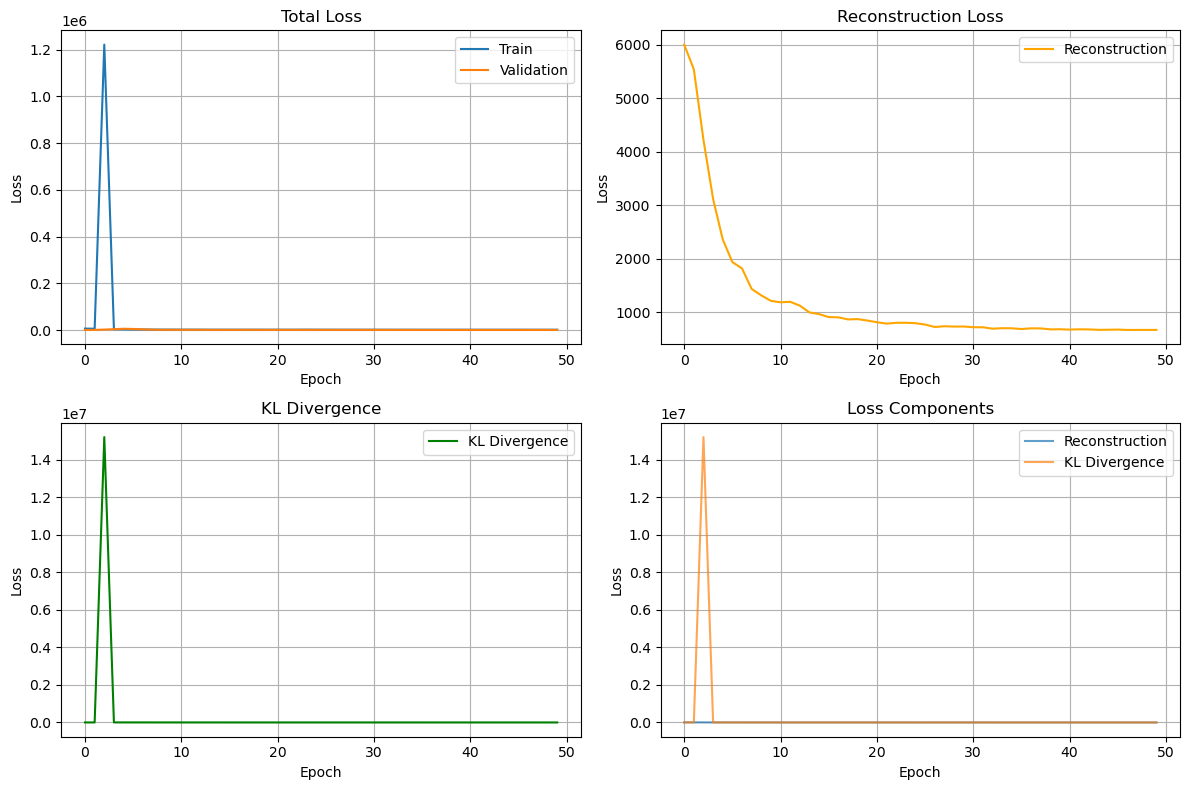

05:26:41 INFO: Training completed successfully!


In [159]:
# Example usage and training script

# Hyperparameters
input_dim = 7690
latent_dim = 1024
hidden_dims = [4096, 4096, 2048, 2048]
epochs = 50
lr = 1e-3
beta = 1.0

# Create model
vae = WeightVAE(input_dim, latent_dim, hidden_dims)
logger.info(f"Created VAE model with {sum(p.numel() for p in model.parameters()):,} parameters")

# Create trainer
trainer = VAETrainer(vae)

# Beta annealing schedule
beta_schedule = lambda epoch: beta_annealing_schedule(epoch, epochs, 0.0, beta)

# Train model
train_losses, val_losses = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    beta=beta,
    beta_schedule=beta_schedule,
    save_dir='./weight_vae_checkpoints',
    save_frequency=20,
    patience=15
)

# Plot results
plot_training_curves(
    train_losses, val_losses, 
    trainer.recon_losses, trainer.kl_losses,
    # save_path='./weight_vae_checkpoints/training_curves.png'
)

# # Test reconstruction
# logger.info("Testing reconstruction...")
# model.eval()
# with torch.no_grad():
#     test_input = val_dataset[0][0].unsqueeze(0).to(trainer.device)
#     recon, mu, logvar = model(test_input)
#     recon_error = F.mse_loss(recon, test_input)
#     logger.info(f"Reconstruction MSE: {recon_error.item():.6f}")

logger.info("Training completed successfully!")

05:26:47 INFO: Generating new MLP weights...
05:26:48 INFO: Reconstructed model 0 accuracy: 91.53%
05:26:49 INFO: Reconstructed model 0 accuracy: 38.14%
05:26:49 INFO: Reconstructed model 1 accuracy: 91.46%
05:26:50 INFO: Reconstructed model 1 accuracy: 39.30%
05:26:50 INFO: Reconstructed model 2 accuracy: 91.75%
05:26:51 INFO: Reconstructed model 2 accuracy: 38.77%
05:26:52 INFO: Reconstructed model 3 accuracy: 91.84%
05:26:52 INFO: Reconstructed model 3 accuracy: 39.22%
05:26:53 INFO: Reconstructed model 4 accuracy: 91.66%
05:26:53 INFO: Reconstructed model 4 accuracy: 39.86%
05:26:54 INFO: Reconstructed model 5 accuracy: 91.07%
05:26:55 INFO: Reconstructed model 5 accuracy: 40.64%
05:26:55 INFO: Reconstructed model 6 accuracy: 91.06%
05:26:56 INFO: Reconstructed model 6 accuracy: 37.41%
05:26:56 INFO: Reconstructed model 7 accuracy: 89.80%
05:26:57 INFO: Reconstructed model 7 accuracy: 39.37%
05:26:58 INFO: Reconstructed model 8 accuracy: 91.37%
05:26:58 INFO: Reconstructed model 8 

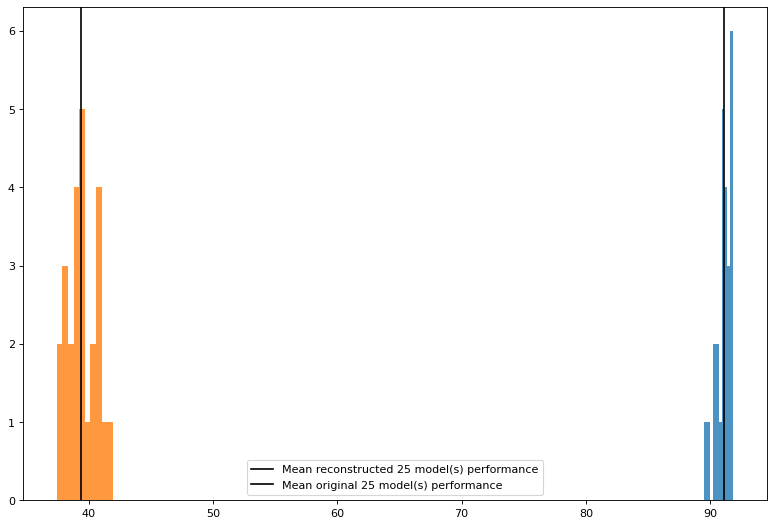

In [161]:
# Generate new MLP weights
logging.info("Generating new MLP weights...")
n_samples = 25


# Convert to MLP weights and save
true_accuracies = []
recon_accuracies = []
for i in range(n_samples):

    # I can also add normal/kaiming-he init untrained models as a control group

    # originals from the validation dataset
    new_wso = WeightSpaceObject.from_flat(
        val_dataset[i][0],
        layers=np.array(layer_layout), 
        device=device
    )

    expected_weight_shapes = [(32, 196), (32, 32), (10, 32)]
    expected_bias_shapes = [(32,), (32,), (10,)]

    assert len(new_wso.weights) == 3, f"Expected 3 weight matrices, got {len(new_wso.weights)}"
    assert len(new_wso.biases) == 3, f"Expected 3 bias vectors, got {len(new_wso.biases)}"
    
    # Check each weight and bias shape
    for j, (w, expected_shape) in enumerate(zip(new_wso.weights, expected_weight_shapes)):
        assert w.shape == expected_shape, f"Weight {j} has shape {w.shape}, expected {expected_shape}"
    
    for j, (b, expected_shape) in enumerate(zip(new_wso.biases, expected_bias_shapes)):
        assert b.shape == expected_shape, f"Bias {j} has shape {b.shape}, expected {expected_shape}"

    # Create and test model
    model = MLP()
    model.fc1.weight.data = new_wso.weights[0].clone()
    model.fc1.bias.data = new_wso.biases[0].clone()
    model.fc2.weight.data = new_wso.weights[1].clone()
    model.fc2.bias.data = new_wso.biases[1].clone()
    model.fc3.weight.data = new_wso.weights[2].clone()
    model.fc3.bias.data = new_wso.biases[2].clone()

    acc = test_mlp(model, test_loader)
    true_accuracies.append(acc)
    logging.info(f"Reconstructed model {i} accuracy: {acc:.2f}%")

    vae.eval()
    # originals from the validation dataset
    new_wso = WeightSpaceObject.from_flat(
        vae(val_dataset[i][0].unsqueeze(0))[0].squeeze(),
        layers=np.array(layer_layout), 
        device=device
    )

    expected_weight_shapes = [(32, 196), (32, 32), (10, 32)]
    expected_bias_shapes = [(32,), (32,), (10,)]

    assert len(new_wso.weights) == 3, f"Expected 3 weight matrices, got {len(new_wso.weights)}"
    assert len(new_wso.biases) == 3, f"Expected 3 bias vectors, got {len(new_wso.biases)}"
    
    # Check each weight and bias shape
    for j, (w, expected_shape) in enumerate(zip(new_wso.weights, expected_weight_shapes)):
        assert w.shape == expected_shape, f"Weight {j} has shape {w.shape}, expected {expected_shape}"
    
    for j, (b, expected_shape) in enumerate(zip(new_wso.biases, expected_bias_shapes)):
        assert b.shape == expected_shape, f"Bias {j} has shape {b.shape}, expected {expected_shape}"

    # Create and test model
    model = MLP()
    model.fc1.weight.data = new_wso.weights[0].clone()
    model.fc1.bias.data = new_wso.biases[0].clone()
    model.fc2.weight.data = new_wso.weights[1].clone()
    model.fc2.bias.data = new_wso.biases[1].clone()
    model.fc3.weight.data = new_wso.weights[2].clone()
    model.fc3.bias.data = new_wso.biases[2].clone()

    acc = test_mlp(model, test_loader)
    recon_accuracies.append(acc)
    logging.info(f"Reconstructed model {i} accuracy: {acc:.2f}%")


plt.figure(figsize=(12, 8), dpi=80)
plt.hist(true_accuracies, alpha = 0.8)
plt.hist(recon_accuracies, alpha = 0.8)

plt.axvline(np.mean(recon_accuracies), color = 'k', label = f"Mean reconstructed {n_samples} model(s) performance")
plt.axvline(np.mean(true_accuracies), color = 'k', label = f"Mean original {n_samples} model(s) performance")

plt.legend()
plt.show()